## Which are organizations or political figures do they tweet about?  What sentiments do they demonstrate when discussing these entities?
### Named entity recognition and sentiment analysis

In [33]:
import os
import re
import numpy as np
import random
import spacy
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from spacy import displacy
from collections import Counter
import en_core_web_md
nlp = en_core_web_md.load()
import gensim
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [4]:
eng_tweets = pd.read_pickle('../data/eng_tweets.p')

In [5]:
eng_tweets.content = eng_tweets.content.apply(lambda x: re.sub(r'"''~',"",str(x)))

In [6]:
eng_tweets.content.head()

0    We have a sitting Democrat US Senator on trial...
1    Marshawn Lynch arrives to game in anti Trump s...
2    Daughter of fallen Navy Sailor delivers powerf...
3    JUST IN President Trump dedicates Presidents C...
4    19000 RESPECTING our National Anthem Stand For...
Name: content, dtype: object

In [7]:
targets = ['RightTroll', 'LeftTroll', 'NewsFeed']
subset = eng_tweets.loc[eng_tweets.account_category.isin(targets)]

In [8]:
#if os.path.exists('../data/eng_tweets_with_entities.csv'):
#    subset = pd.read_csv('../data/eng_tweets_with_entities.csv', 
#                         converters={"entities": lambda x: x.strip("[]").split(", "), 
#                                     "labels": lambda x: x.strip("[]").split(", ")})
#else:

subset['docs'] = subset.content.apply(nlp)

In [9]:
subset['entities'] = subset.docs.apply(lambda doc: [ent.text for ent in doc.ents])
subset['labels'] = subset.docs.apply(lambda doc: [ent.label_ for ent in doc.ents])
subset['sentences'] = subset.docs.apply(lambda doc: [sent for sent in doc.sents])

In [10]:
flattened_entities = subset.entities.tolist()
flattened_entities = pd.Series([str(item) for sublist in flattened_entities for item in sublist])
#flattened_entities = flattened_entities.loc[flattened_entities != ''].astype(str)

flattened_labels = subset.labels.tolist()
flattened_labels = pd.Series([str(item) for sublist in flattened_labels for item in sublist])
#flattened_labels = flattened_labels.loc[flattened_labels != ''].astype(str)
flattened_entities.to_csv('../data.flattened_entities.csv')
flattened_labels.to_csv('../data.flattened_labels.csv')

In [11]:
top20 = Counter(flattened_entities).most_common(20)
top20

[('US', 35854),
 ('Trump', 31102),
 ('Obama', 25498),
 ('Donald Trump', 20204),
 ('Hillary', 18592),
 ('2', 15422),
 ('America', 14341),
 ('GOP', 13905),
 ('CNN', 11916),
 ('Russia', 10785),
 ('Hillary Clinton', 10780),
 ('Texas', 10488),
 ('American', 10424),
 ('first', 10203),
 ('Cleveland', 10128),
 ('Clinton', 9900),
 ('one', 9680),
 ('ISIS', 9412),
 ('today', 9096),
 ('Syria', 8978)]

In [12]:
flattened_labels.value_counts()

ORG            770697
PERSON         710775
GPE            488598
CARDINAL       232864
NORP           170519
DATE           167406
WORK_OF_ART     50988
LOC             43147
PRODUCT         28553
ORDINAL         27886
FAC             26674
EVENT           25040
TIME            20311
LAW              8350
QUANTITY         5383
MONEY            3020
PERCENT          1941
LANGUAGE          769
dtype: int64

In [13]:
people = flattened_entities.loc[flattened_labels=='PERSON']
top20people = Counter(people).most_common(20)
top20people = [x[0] for x in top20people]
top20people

['Donald Trump',
 'Hillary',
 'Hillary Clinton',
 'Obama',
 'Clinton',
 'Trump',
 'Putin',
 'Bernie Sanders',
 'Bernie',
 'Ted Cruz',
 'Trumps',
 'Sanders',
 'Bill Clinton',
 'Comey',
 'Barack Obama',
 'Oscar',
 'Cruz',
 'Mc Cain',
 'Jesus',
 'Zika']

In [14]:
org = flattened_entities.loc[flattened_labels=='ORG']
top20org = Counter(org).most_common(20)
top20org = [x[0] for x in top20org]
top20org

['Trump',
 'Obama',
 'GOP',
 'CNN',
 'ISIS',
 'POTUS',
 'FBI',
 'NFL',
 'MAGA',
 'Islam',
 'Fox News',
 'Congress',
 'Senate',
 'EU',
 'UN',
 'PJNET',
 'House',
 'White House',
 'Obamacare',
 'DNC']

In [15]:
gpe = flattened_entities.loc[flattened_labels=='GPE']
top20gpe = Counter(gpe).most_common(20)
top20gpe = [x[0] for x in top20gpe]
top20gpe

['US',
 'America',
 'Russia',
 'Texas',
 'Cleveland',
 'Syria',
 'Chicago',
 'Miami',
 'California',
 'China',
 'Iran',
 'San Jose',
 'North Korea',
 'Ohio',
 'Florida',
 'Baltimore',
 'New Orleans',
 'Turkey',
 'Iraq',
 'Charlottesville']

In [25]:
norp = flattened_entities.loc[flattened_labels=='NORP']
top20norp = Counter(norp).most_common(20)
top20norp = [x[0] for x in top20norp]
top20norp

['American',
 'Democrats',
 'Americans',
 'Muslim',
 'Russian',
 'Syrian',
 'Dems',
 'Islamic',
 'Republicans',
 'Republican',
 'Dem',
 'Democrat',
 'Muslims',
 'Antifa',
 'French',
 'Turkish',
 'German',
 'Chinese',
 'British',
 'Democratic']

In [16]:
for i in range(20):
    displacy.render(nlp(str(subset.sentences.loc[i])), jupyter=True, style='ent')

### Sentiment analysis

In [18]:
analyzer = SentimentIntensityAnalyzer()

In [19]:
subset['sentiment'] = subset.content.astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [20]:
def get_polarity(sentiment):
    if sentiment > 0.05:
        return 'Positive'
    if sentiment < -0.05:
        return 'Negative'
    else:
        return 'Neutral'
subset['polarity'] = subset.sentiment.apply(get_polarity)

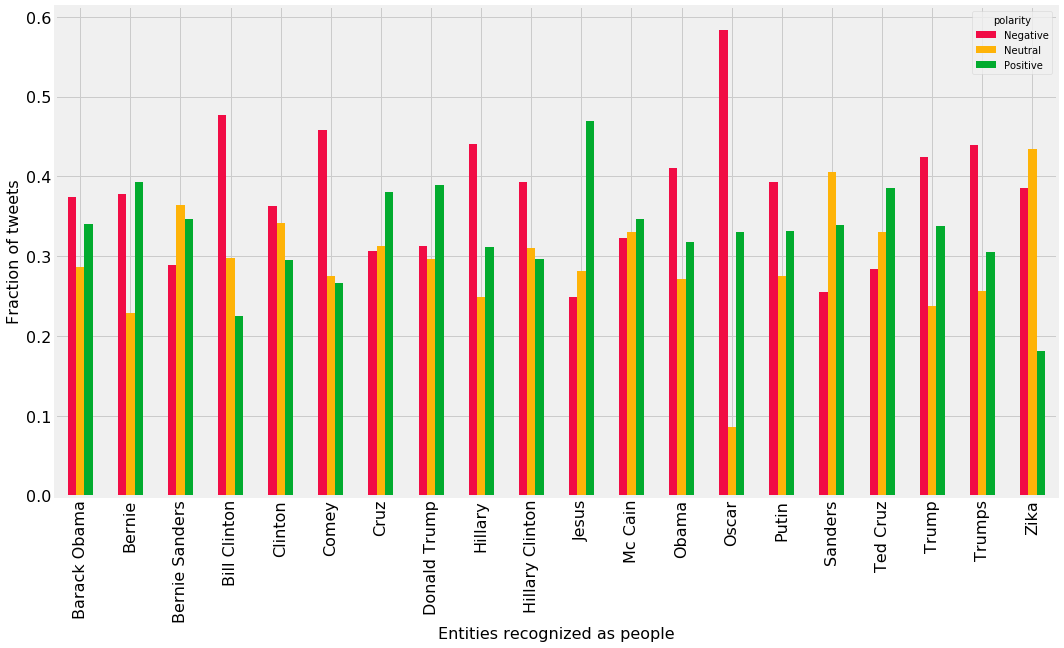

In [21]:
top20people_polarity = (subset[['entities','polarity']].loc[subset.content
                        .apply(lambda string: any(x in string for x in top20people))])
top20people_polarity = (top20people_polarity.entities.apply(pd.Series)
                        .merge(top20people_polarity, left_index = True, right_index = True)
                        .drop(['entities'], axis = 1)
                        .melt(id_vars = ['polarity'], value_name = 'entity')
                        .drop(['variable'], axis=1)
                       )
top20people_polarity = (top20people_polarity.loc[top20people_polarity.entity
                        .apply(lambda string: any(x == str(string) for x in top20people))])
top20people_polarity = top20people_polarity.groupby(['entity','polarity']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
ax = top20people_polarity.plot(kind = 'bar', figsize=(16,9), color=['#f10c45','#feb308','#02ab2e'], fontsize=16)
ax.set_xlabel("Entities recognized as people", fontsize=16)
ax.set_ylabel("Fraction of tweets", fontsize=16);

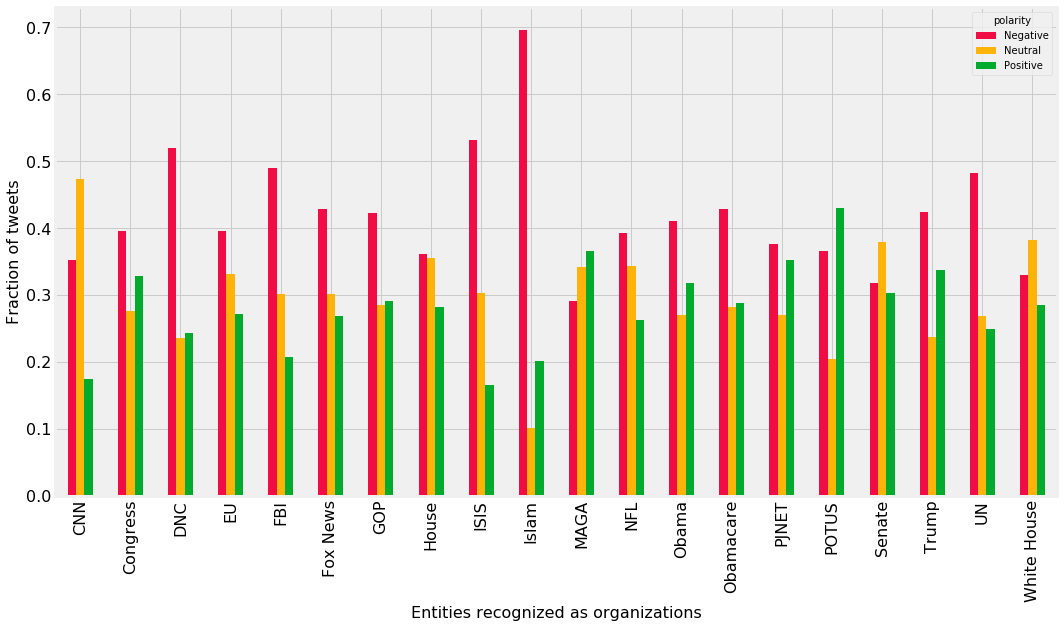

In [22]:
top20org_polarity = (subset[['entities','polarity']].loc[subset.content
                        .apply(lambda string: any(x in string for x in top20org))])
top20org_polarity = (top20org_polarity.entities.apply(pd.Series)
                        .merge(top20org_polarity, left_index = True, right_index = True)
                        .drop(['entities'], axis = 1)
                        .melt(id_vars = ['polarity'], value_name = 'entity')
                        .drop(['variable'], axis=1)
                       )
top20org_polarity = (top20org_polarity.loc[top20org_polarity.entity
                        .apply(lambda string: any(x == str(string) for x in top20org))])
top20org_polarity = top20org_polarity.groupby(['entity','polarity']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
ax = top20org_polarity.plot(kind = 'bar', figsize=(16,9), color=['#f10c45','#feb308','#02ab2e'], fontsize=16)
ax.set_xlabel("Entities recognized as organizations", fontsize=16)
ax.set_ylabel("Fraction of tweets", fontsize=16);

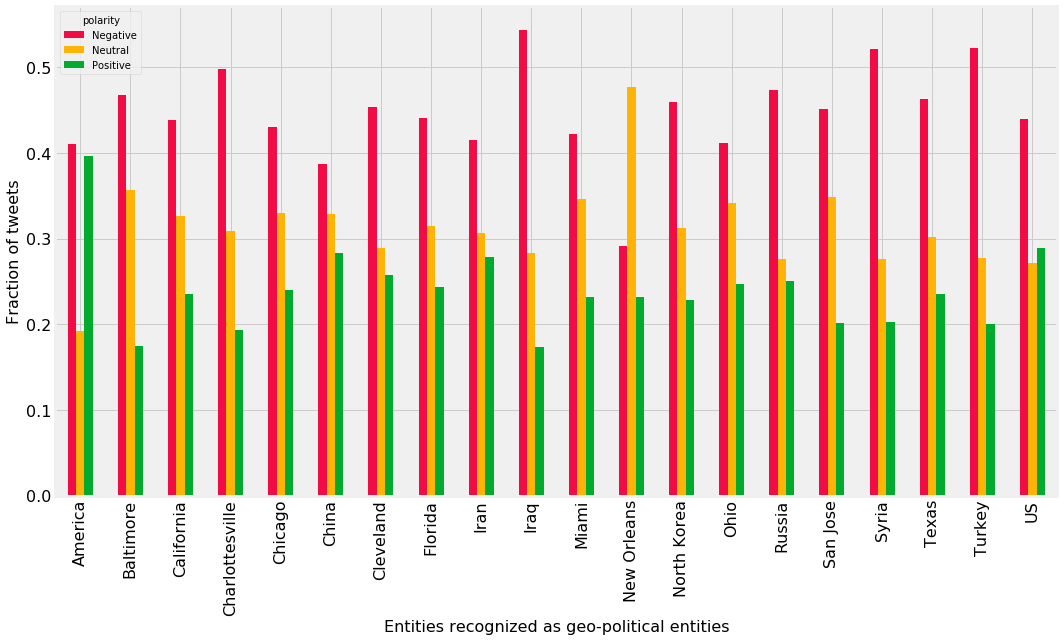

In [23]:
top20gpe_polarity = (subset[['entities','polarity']].loc[subset.content
                        .apply(lambda string: any(x in string for x in top20gpe))])
top20gpe_polarity = (top20gpe_polarity.entities.apply(pd.Series)
                        .merge(top20gpe_polarity, left_index = True, right_index = True)
                        .drop(['entities'], axis = 1)
                        .melt(id_vars = ['polarity'], value_name = 'entity')
                        .drop(['variable'], axis=1)
                       )
top20gpe_polarity = (top20gpe_polarity.loc[top20gpe_polarity.entity
                        .apply(lambda string: any(x == str(string) for x in top20gpe))])
top20gpe_polarity = top20gpe_polarity.groupby(['entity','polarity']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
ax = top20gpe_polarity.plot(kind = 'bar', figsize=(16,9), color=['#f10c45','#feb308','#02ab2e'], fontsize=16)
ax.set_xlabel("Entities recognized as geo-political entities", fontsize=16)
ax.set_ylabel("Fraction of tweets", fontsize=16);

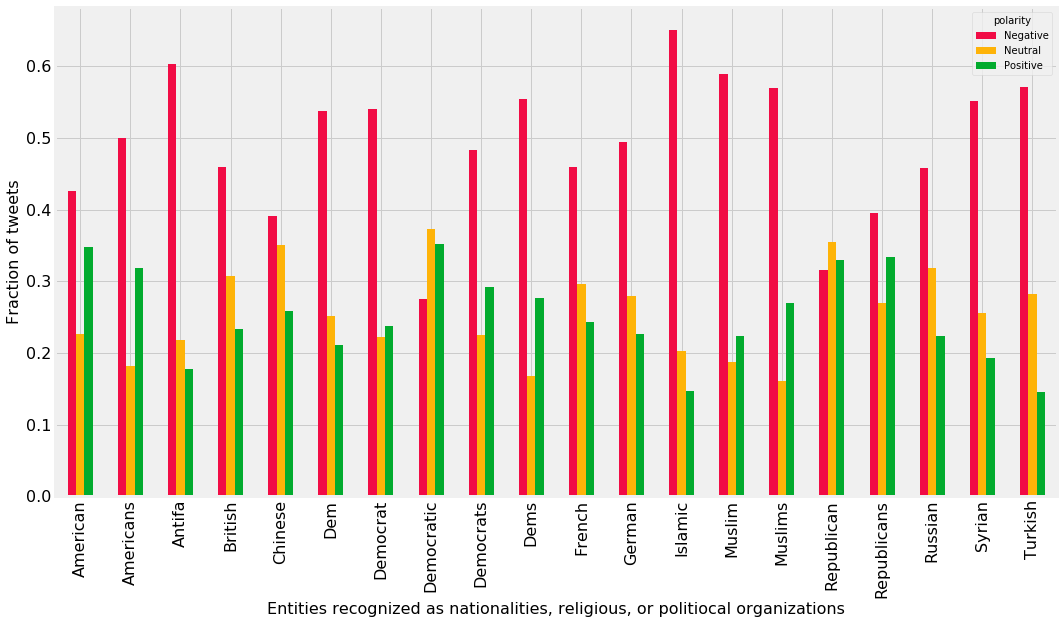

In [27]:
top20norp_polarity = (subset[['entities','polarity']].loc[subset.content
                        .apply(lambda string: any(x in string for x in top20norp))])
top20norp_polarity = (top20norp_polarity.entities.apply(pd.Series)
                        .merge(top20norp_polarity, left_index = True, right_index = True)
                        .drop(['entities'], axis = 1)
                        .melt(id_vars = ['polarity'], value_name = 'entity')
                        .drop(['variable'], axis=1)
                       )
top20norp_polarity = (top20norp_polarity.loc[top20norp_polarity.entity
                        .apply(lambda string: any(x == str(string) for x in top20norp))])
top20norp_polarity = top20norp_polarity.groupby(['entity','polarity']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
ax = top20norp_polarity.plot(kind = 'bar', figsize=(16,9), color=['#f10c45','#feb308','#02ab2e'], fontsize=16)
ax.set_xlabel("Entities recognized as nationalities, religious, or politiocal organizations", fontsize=16)
ax.set_ylabel("Fraction of tweets", fontsize=16);

In [ ]:
subset.to_csv('../data/eng_tweets_with_entities.csv')